추가 내용) 기존에 validation set이 없었던것을 추가함.   
validation loss가 증가하는 구간 체크, 드롭아웃, LSTM 노드수 설정하여 재학습  
**테스트 시에 런타임 유형을 "GPU"로 설정하는 것을 권장합니다.**

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# 네이버 영화리뷰 데이터셋 불러오기
file = tf.keras.utils.get_file(
    'ratings_train.txt',
    origin='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt',
    extract=True)

df = pd.read_csv(file, sep='\t')

14628807/14628807 [==============================] - 0s 0us/step


In [ ]:
len(df)

150000

In [ ]:
# 데이터 임의샘플 확인
df[1262:1272]

,id,document,label
1262,5027645,간만에 잘만든영화봣다 불륜의내면심리를 제대로 분석한 아트작이다 유럽영화짱,1
1263,8934341,이 영화 시리즈로 인해 나는 휴 잭맨 팬이 되었다고 한다 ㅋ,1
1264,915148,한번쯤 이 여인들처럼 떠나보고 싶어지게 하는 영화.,1
1265,4295299,이건 또 뭔가요;;;,0
1266,3816306,"빨간 풍선을 따라가는 아이, 아이를 통해 행복해지는 이들.. 아름답다..",1
1267,2907640,휴.. 나 이거 왜봤지..,0
1268,9855891,나름 그냥 그저그런 영화,0
1269,5815880,조엘 슈마허 최악의 영화 차라리 배트맨과 로빈이 좋음,0
1270,9413946,"대단한 것일 줄 착각. 재미도 없고, 긴장감도 없고.",0
1271,8683953,이영화의 유일한 미덕인 태국가요를 재조명 해주었다는데 이 별을 바친다.태국노래 cd...,0


In [ ]:
# 형태소 분석기 -> 한국어 텍스트를 형태소 단위로 분리 작업 수행
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.7 MB/s eta 0:00:00


In [ ]:
# 데이터 전처리
def word_tokenization(text):
  return [word for word in okt.morphs(text)] #입력된 텍스트를 형태소 단위로 분리

def preprocessing(df):
  df = df.dropna()  #데이터에서 결측값이 있는 행을 제거
  df['document'] = df['document'].str.replace("[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]","") #영문자, 숫자, 한글만 남기고 제거
  data =  df['document'].apply((lambda x: word_tokenization(x)))
  return data

In [ ]:
# 텍스트 데이터 1000개 전처리 후 불러오기
review = preprocessing(df[1000:2000])

#validation set 코드 추가
valid_review = df[2000:2500] #validation set은 train set과 다르게 설정
valid_review = preprocessing(valid_review) #형태소 분리 함수 호출
print(len(review)) #테스트 프린트
print(len(valid_review))


<ipython-input-7-8a4ae9934285>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document'] = df['document'].str.replace("[^A-Za-z0-9가-힣ㄱ-ㅎㅏ-ㅣ ]","") #영문자, 숫자, 한글만 남기고 제거


1000
500


In [ ]:
# 형태소 분리된 데이터 확인
print(review[:10]) #10개 data만 확인
print(valid_review[:10])

1000    [정말, 최고, 의, 명작, 성인, 이, 되고, 본, 이집트, 의, 왕자, 는, 또...
1001    [이영화, 만, 성공, 했어도, 스퀘어, 가, 에, 닉스, 랑, 합병, 할, 일, ...
1002                                 [울컥, 하는, 사회, 현실, ㅠㅠ]
1003       [기대, 를, 하나, 도안, 하, 면, 할, 일, 없을, 때, 보기, 좋은, 영화]
1004    [소림사, 관문, 통과, 하기, 진짜, 어렵다는거, 보여준, 영화, 극장, 에서, ...
1005                              [시리즈, 안, 나오나, ㅠㅠㅠㅠㅠㅠㅠㅠ]
1006        [끝난다는, 사실, 이, 너무, 슬퍼요, 가슴, 이, 뻥, 뚫려, 버린것, 같아]
1007                                             [펑점, 조절]
1008                            [와이, 건, 진짜, 으리, 으리, 한, 데]
1009                                [손발, 이, 오, 그라드, 네, 요]
Name: document, dtype: object
2000                                   [최최최, 최악, 악, 악, 악]
2001                   [10, 점, 외, 에, 줄, 수, 있는, 점수, 는, 없다]
2002                [동성애, 에, 대한, 편견, 과, 불쾌감, 을, 심어주는, 영화]
2003    [큰, 재미, 는, 없지만, 나름, 대로, 의미, 는, 있는듯, 4, 명의, 배우,...
2004    [이건, 진짜, 6, 점, 이, 적당함, 평점, 내려야, 됨, 화끈한, 액션, 이,...
2005                                 [이, 때, 부터가, 쓰레기, 였지]
2006         [잘못, 참, 햇, 지만, 아이, 를, 통해, 불행했

In [ ]:
# 동적 N-GRAM 시퀀스 생성
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#리뷰 데이터를 토큰화, n-gram 시퀀스 형태로 변환
def get_sequences(review, tokenizer):
  tokenized_sentences = tokenizer.texts_to_sequences(review)

  input_sequences = []
  for token in tokenized_sentences:
    for t in range(1, len(token)):
        n_gram_sequence = token[:t+1] #연속된 토큰 끼리 묶어서 시퀀스 생성
        input_sequences.append(n_gram_sequence) #input_sequences 리스트에 추가

  return input_sequences

##여기부터
tokenizer = Tokenizer(num_words=4000) #형태소 개수 4000개로 고정(벡터값 1~4000)
tokenizer.fit_on_texts(review) #리뷰 데이터 단어 사전에 매핑
total_words = 4000

input_sequences = get_sequences(review, tokenizer) #get_sequences 함수 호출 -> train
valid_input_sequences = get_sequences(valid_review, tokenizer) #get_sequences 함수 호출 -> validation

print(input_sequences[:10])        # n_gram으로 리스트된 데이터샘플 확인
print(valid_input_sequences[:10])
print(total_words) #형태소 개수 4000개

[[14, 31], [14, 31, 3], [14, 31, 3, 139], [14, 31, 3, 139, 538], [14, 31, 3, 139, 538, 1], [14, 31, 3, 139, 538, 1, 410], [14, 31, 3, 139, 538, 1, 410, 63], [14, 31, 3, 139, 538, 1, 410, 63, 1380], [14, 31, 3, 139, 538, 1, 410, 63, 1380, 3], [14, 31, 3, 139, 538, 1, 410, 63, 1380, 3, 790]]
[[97, 2313], [97, 2313, 2313], [97, 2313, 2313, 2313], [81, 15], [81, 15, 753], [81, 15, 753, 7], [81, 15, 753, 7, 196], [81, 15, 753, 7, 196, 95], [81, 15, 753, 7, 196, 95, 115], [81, 15, 753, 7, 196, 95, 115, 233]]
4000


In [ ]:
len(input_sequences) #시퀀스 길이가 총 11358개

11358

In [ ]:
#패딩
# 훈련 데이터와 검증 데이터의 시퀀스 길이 중 최대값을 계산 -> 수정
# 훈련의 입력 시퀀스 길이를 통일시켜주기 위함.
max_len = max(max([len(word) for word in input_sequences]),  #인풋 시퀀스의 가장 긴 리스트 길이를 반환
              max([len(word) for word in valid_input_sequences])) #검증 시퀀스의 가장 긴 n-gram에서 n을 반환

print("max_len:", max_len) #59-gram 리스트가 최대인것을 확인

#모델의 입력 시퀀스 길이를 맞춰주기 위해 len이 59가 아닌 리스트 값들을 0값으로 패딩
train_input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_len,
                                         padding='pre'))

#코드 추가 -> validation set도 마찬가지로 시퀀스 길이를 59로 통일시켜줌
print("valid_max_len:", max_len)
valid_input_sequences = np.array(pad_sequences(valid_input_sequences,
                                         maxlen=max_len,
                                         padding='pre'))

max_len: 59
valid_max_len: 59


In [ ]:
# 입력텍스트와 타겟
from tensorflow.keras.utils import to_categorical

X = train_input_sequences[:,:-1]  # 마지막 값은 제외함
y = to_categorical(train_input_sequences[:,-1],
                   num_classes=total_words) # 마지막 형태소 값을 예측하기 위한 clssification 문제로 활용

valid_X = valid_input_sequences[:,:-1]  # 마지막 값은 제외함
valid_y = to_categorical(valid_input_sequences[:,-1],
                   num_classes=total_words) # 마지막 값만 원-핫 인코딩 벡터로 변환 (형태소 4000개)

In [ ]:
# y를 설명하기 위한 예시 -> 원핫 인코딩
a = to_categorical([0, 1, 2, 3], num_classes=4)
a

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
len(y)

11358

In [ ]:
len(y[0])

4000

In [ ]:
len(X[0])

58

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

embedding_dim = 256

model = Sequential([
    Embedding(input_dim=total_words,   #입력 차원 : 4000
              output_dim=embedding_dim,#출력 차원 : 256
              input_length=max_len-1), #입력 시퀀스 길이 : 59 - 1(마지막 시퀀스를 예측하기 위함)
    Bidirectional(LSTM(units=256)),
    Dense(units=total_words, activation='softmax'), #마지막 레이어 : 4000개 시퀀스 classification
])
model.compile(loss='categorical_crossentropy', #원-핫 인코딩 벡터
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(
         x=X,
         y=y,
         epochs=20, #초기 에폭 수 : 20
         validation_data=(valid_X, valid_y),#validation set 성능 평가 위해 추가,
         batch_size = 32, #배치사이즈 default 값 : 32개임
         verbose=1)

Epoch 1/20
355/355 [==============================] - 33s 64ms/step - loss: 7.5691 - accuracy: 0.0253 - val_loss: 6.7369 - val_accuracy: 0.0411
Epoch 2/20
355/355 [==============================] - 9s 26ms/step - loss: 7.0016 - accuracy: 0.0365 - val_loss: 6.5725 - val_accuracy: 0.0434
Epoch 3/20
355/355 [==============================] - 7s 19ms/step - loss: 6.6305 - accuracy: 0.0445 - val_loss: 6.6508 - val_accuracy: 0.0518
Epoch 4/20
355/355 [==============================] - 7s 20ms/step - loss: 6.0361 - accuracy: 0.0675 - val_loss: 6.6675 - val_accuracy: 0.0624
Epoch 5/20
355/355 [==============================] - 6s 16ms/step - loss: 5.2157 - accuracy: 0.1027 - val_loss: 6.9196 - val_accuracy: 0.0647
Epoch 6/20
355/355 [==============================] - 6s 16ms/step - loss: 4.3044 - accuracy: 0.1751 - val_loss: 7.1649 - val_accuracy: 0.0652
Epoch 7/20
355/355 [==============================] - 6s 18ms/step - loss: 3.4199 - accuracy: 0.3177 - val_loss: 7.3795 - val_accuracy: 0.067

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 58, 256)           1024000   
                                                                 
 bidirectional (Bidirection  (None, 512)               1050624   
 al)                                                             
                                                                 
 dense (Dense)               (None, 4000)              2052000   
                                                                 
Total params: 4126624 (15.74 MB)
Trainable params: 4126624 (15.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


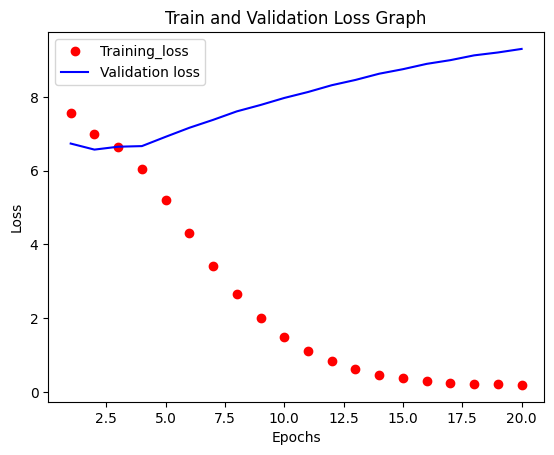

In [ ]:
#코드 추가 -> 정확도 및 손실 그래프 그리기
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, "ro", label="Training_loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Train and Validation Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

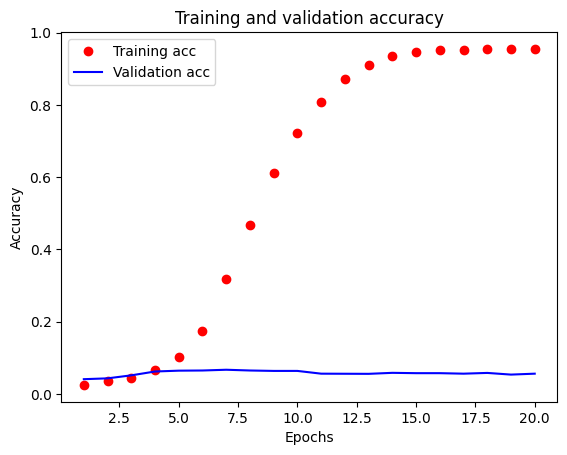

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "ro", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# 문장생성함수 (시작 텍스트, 생성 단어 개수)
def text_generation(sos, count): #형태소 시퀀스 1개 기반으로 텍스트를 생성하는 함수
    for _ in range(1, count):
        token_list = tokenizer.texts_to_sequences([sos])[0] #sos 형태소를 토큰화
        #남은 시퀀스 길이 0으로 패딩
        #[325] -> [0, 0, 0,  ... 0, 325]
        token_list = pad_sequences([token_list],
                                   maxlen=max_len-1, #다음 시퀀스 예측 -> max_len-1으로 세팅
                                   padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=1) # model.predict -> 최댓값 인덱스를 반환(0~3999)
        #print(token_list)
        print(predicted)

        #단어 사전 검사하면서 인덱스에 매핑되는 단어 리턴
        for word, idx in tokenizer.word_index.items():
            if idx == predicted:
                output = word
                break
        sos += " " + output #최종 출력부에 형태소를 합쳐줌
    return sos #시퀀스 출력부 반환

In [ ]:
# argmax 설명: 최대값의 인덱스 반환
data = [[0.1, 0.2, 0.7], [0.3, 0.5, 0.2], [0.4, 0.3, 0.3]]
np.argmax([data], axis=-1)

array([[2, 1, 0]])

In [ ]:
text_generation("배우", 8)

1/1 [==============================] - 0s 20ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 41]]
[8]
1/1 [==============================] - 0s 22ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 41  8]]
[29]
1/1 [==============================] - 0s 20ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0 41  8 29]]
[6]
1/1 [==============================] - 0s 24ms/step
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 41  8 29  6]]
[37]
1/1 [==============================] - 0s 19ms

'배우 들 연기 도 잘 하고 재미있어요 ㅋㅋ'

In [ ]:
text_generation("꿀잼", 12)

1/1 [==============================] - 0s 19ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[436]
1/1 [==============================] - 0s 19ms/step
[28]
1/1 [==============================] - 0s 19ms/step
[223]
1/1 [==============================] - 0s 19ms/step
[49]
1/1 [==============================] - 0s 19ms/step
[5]
1/1 [==============================] - 0s 24ms/step
[1843]
1/1 [==============================] - 0s 19ms/step
[1844]
1/1 [==============================] - 0s 18ms/step
[119]
1/1 [==============================] - 0s 18ms/step
[62]
1/1 [==============================] - 0s 20ms/step
[62]


'꿀잼 영화 추억 이다 ㅜㅜ 스토리 가 없는것 같군요 난 왜 왜'

In [ ]:
text_generation("눈물 이", 12)

1/1 [==============================] - 0s 18ms/step
[940]
1/1 [==============================] - 0s 18ms/step
[4]
1/1 [==============================] - 0s 18ms/step
[3007]
1/1 [==============================] - 0s 17ms/step
[3008]
1/1 [==============================] - 0s 18ms/step
[176]
1/1 [==============================] - 0s 22ms/step
[10]
1/1 [==============================] - 0s 18ms/step
[3009]
1/1 [==============================] - 0s 18ms/step
[75]
1/1 [==============================] - 0s 18ms/step
[75]
1/1 [==============================] - 0s 17ms/step
[71]
1/1 [==============================] - 0s 18ms/step
[16]


'눈물 이 길 을 가다 죽었다 이유 는 차가와 서 서 더 다'

In [ ]:
text_generation("손발 이", 12)

1/1 [==============================] - 0s 18ms/step
[1402]
1/1 [==============================] - 0s 20ms/step
[1403]
1/1 [==============================] - 0s 22ms/step
[89]
1/1 [==============================] - 0s 20ms/step
[57]
1/1 [==============================] - 0s 18ms/step
[57]
1/1 [==============================] - 0s 20ms/step
[77]
1/1 [==============================] - 0s 22ms/step
[5]
1/1 [==============================] - 0s 21ms/step
[1337]
1/1 [==============================] - 0s 21ms/step
[1170]
1/1 [==============================] - 0s 21ms/step
[696]
1/1 [==============================] - 0s 21ms/step
[53]


'손발 이 오 그라드 네 요 요 대 가 그려 준 그림 보고'

In [ ]:
text_generation("박수 가", 8)

1/1 [==============================] - 0s 22ms/step
[1369]
1/1 [==============================] - 0s 21ms/step
[1320]
1/1 [==============================] - 0s 20ms/step
[1]
1/1 [==============================] - 0s 33ms/step
[109]
1/1 [==============================] - 0s 20ms/step
[34]
1/1 [==============================] - 0s 19ms/step
[15]
1/1 [==============================] - 0s 20ms/step
[77]


'박수 가 나오네요 벌써 이 ㅠㅠ 1 점 대'

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

embedding_dim = 128

model = Sequential([
    Embedding(input_dim=total_words,
              output_dim=embedding_dim,
              input_length=max_len-1),
    Bidirectional(LSTM(units=128)),
    Dropout(0.2),  # 드롭아웃 레이어 추가
    Dense(units=total_words, activation='softmax'),
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

#재학습 시에 에폭수 10 으로 조정
history = model.fit(
         x=X,
         y=y,
         epochs=10,
         validation_data=(valid_X, valid_y),
         verbose=1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 58, 128)           512000    
                                                                 
 bidirectional_14 (Bidirect  (None, 256)               263168    
 ional)                                                          
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 4000)              1028000   
                                                                 
Total params: 1803168 (6.88 MB)
Trainable params: 1803168 (6.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
355/355 [==============================] - 27s 62ms/step - loss: 7.580

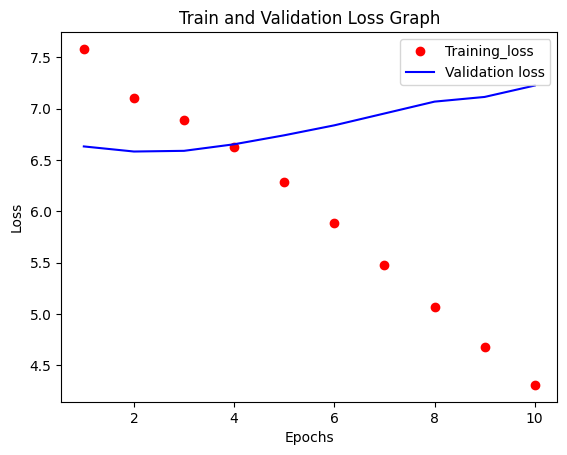

In [ ]:
#코드 추가 -> 정확도 및 손실 그래프 그리기
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, "ro", label="Training_loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Train and Validation Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

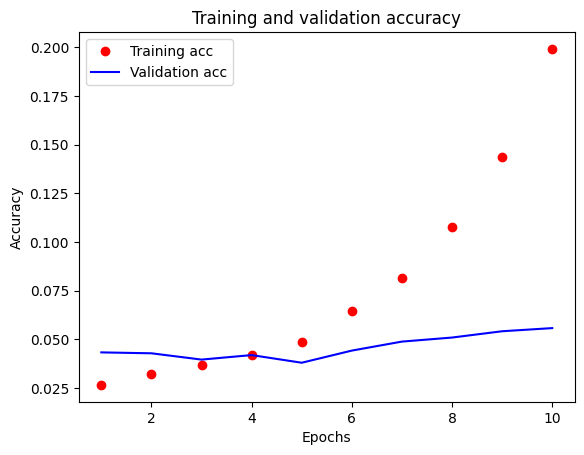

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "ro", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
text_generation("배우", 8)

1/1 [==============================] - 1s 930ms/step
[8]
1/1 [==============================] - 0s 168ms/step
[1]
1/1 [==============================] - 0s 34ms/step
[19]
1/1 [==============================] - 0s 31ms/step
[106]
1/1 [==============================] - 0s 28ms/step
[177]
1/1 [==============================] - 0s 41ms/step
[55]
1/1 [==============================] - 0s 20ms/step
[27]


'배우 들 이 너무 봤는데 봤어요 지 드라마'

In [ ]:
text_generation("손발 이", 12)

1/1 [==============================] - 0s 20ms/step
[39]
1/1 [==============================] - 0s 18ms/step
[68]
1/1 [==============================] - 0s 18ms/step
[55]
1/1 [==============================] - 0s 23ms/step
[39]
1/1 [==============================] - 0s 19ms/step
[2]
1/1 [==============================] - 0s 18ms/step
[5]
1/1 [==============================] - 0s 20ms/step
[62]
1/1 [==============================] - 0s 19ms/step
[25]
1/1 [==============================] - 0s 29ms/step
[43]
1/1 [==============================] - 0s 27ms/step
[43]
1/1 [==============================] - 0s 29ms/step
[8]


'손발 이 거 뭐 지 거 영화 가 왜 하는 ㅋㅋ ㅋㅋ 들'

In [ ]:
text_generation("오랜만에", 6)

1/1 [==============================] - 0s 21ms/step
[52]
1/1 [==============================] - 0s 19ms/step
[2]
1/1 [==============================] - 0s 19ms/step
[9]
1/1 [==============================] - 0s 18ms/step
[167]
1/1 [==============================] - 0s 18ms/step
[285]


'오랜만에 때 영화 를 가장 좋아하는'

In [ ]:
text_generation("추억", 8)

1/1 [==============================] - 0s 19ms/step
[3]
1/1 [==============================] - 0s 22ms/step
[2]
1/1 [==============================] - 0s 20ms/step
[9]
1/1 [==============================] - 0s 19ms/step
[37]
1/1 [==============================] - 0s 20ms/step
[1460]
1/1 [==============================] - 0s 20ms/step
[18]
1/1 [==============================] - 0s 19ms/step
[3336]


'추억 의 영화 를 잘 읽던지 으로 줬다면'

In [ ]:
text_generation("스릴", 5)

1/1 [==============================] - 0s 20ms/step
[369]
1/1 [==============================] - 0s 18ms/step
[13]
1/1 [==============================] - 0s 18ms/step
[2]
1/1 [==============================] - 0s 18ms/step
[10]


'스릴 접 한 영화 는'